<a href="https://colab.research.google.com/github/Satwikram/Tensorflow-Notebooks/blob/master/Natural_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""
@Author: Satwik Ram K

"""
# Connecting Kaggle

from google.colab import files

files.upload()


! mkdir ~/.kaggle


! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json



Saving kaggle.json to kaggle.json


In [2]:
!kaggle datasets download -d prasunroy/natural-images 

 98% 337M/342M [00:05<00:00, 81.0MB/s]
100% 342M/342M [00:05<00:00, 60.4MB/s]


In [ ]:
!unzip /content/natural-images.zip

In [1]:
img_size = (180, 180, 3)
batch_size = 32

In [8]:
pip install tf-nightly

     |████████████████████████████████| 324.5MB 27kB/s 
     |████████████████████████████████| 6.8MB 43.2MB/s 
     |████████████████████████████████| 460kB 57.5MB/s 


In [2]:
# Importing Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory as load_dir

In [3]:
data_dir = '/content/natural_images'

In [4]:
train_data = load_dir(
    data_dir,
    seed = 388,
    subset = 'training',
    validation_split = 0.2,
    image_size = img_size[:2]
    )

Found 6899 files belonging to 8 classes.
Using 5520 files for training.


In [5]:
val_data = load_dir(
    data_dir,
    seed = 388,
    subset = 'validation',
    validation_split = 0.2,
    image_size = img_size[:2]
    )

Found 6899 files belonging to 8 classes.
Using 1379 files for validation.


In [6]:
class_names = train_data.class_names

In [7]:
class_names

['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']

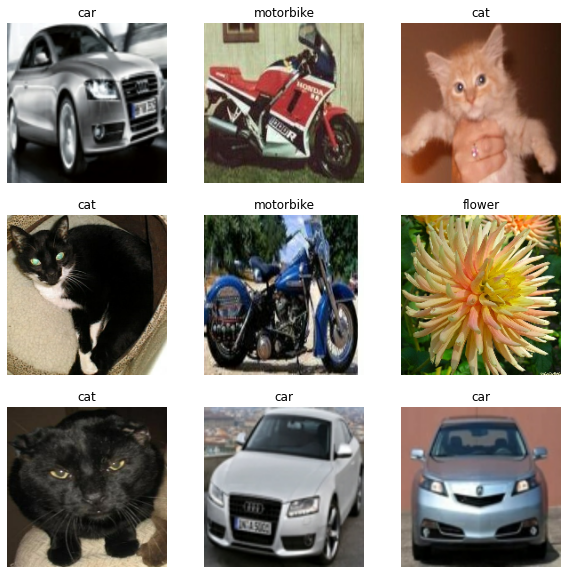

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Normalizing the data

In [12]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [13]:
normalized_ds = train_data.map(lambda x, y: (normalization_layer(x), y))

In [15]:
import numpy as np

In [19]:
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 


0.0 0.86900955


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout

In [22]:
def build_model():

  model = Sequential()

  model.add(Conv2D(32, (5,5), padding = 'same', input_shape = img_size, activation = 'relu'))
  model.add(MaxPooling2D(padding = 'same'))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Conv2D(64, (5,5), padding = 'same',activation = 'relu'))
  model.add(MaxPooling2D(padding = 'same'))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Conv2D(256, (5,5), padding = 'same',activation = 'relu'))
  model.add(MaxPooling2D(padding = 'same'))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Flatten())

  model.add(Dense(512, activation = 'relu'))
  model.add(Dense(8, activation = 'softmax'))

  return model




In [23]:
model = build_model()

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 180, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 90, 90, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 45, 45, 64)        2

In [25]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [26]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

                     
checkpoint = ModelCheckpoint("emotions.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

In [27]:
callbacks = [checkpoint, earlystop]

In [28]:
model.fit(normalized_ds,batch_size=batch_size,validation_data=val_data,epochs=3)

Epoch 1/3
 68/173 [==========>...................] - ETA: 10:20 - loss: 1.9480 - accuracy: 0.3225

KeyboardInterrupt: ignored